## 사이킷런 기초 
* https://scikit-learn.org/stable/getting_started.html

In [1]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

X = [[ 1,  2,  3],  # 2 samples, 3 features
     [11, 12, 13]]
y = [0, 1]  # classes of each sample
clf.fit(X, y)
clf.predict(X)
clf.predict([[4, 5, 6], [14, 15, 16]])

array([0, 1])

## 서울시 공공자전거 따릉이 데이터 담당자가 되어 분류 알고리즘으로 데이터를 관리해 보세요.

* 따릉이 데이터를 관리하는 관리자라 가정하고 이번 태스크를 진행해 봅니다.
* 여러 분은 전임자로 부터 따릉이 데이터를 받았습니다. 자치구별로 따릉이 관리 현황을 관리하고자 하는데 일부 데이터에 해당 자치구에 대한 정보가 기입되어 있지 않습니다. 기존 주소를 보고 하나씩 레이블링 할 수도 있지만 머신러닝 기술을 사용하여 데이터를 자치구를 분류해 볼 수도 있을 것입니다. 또, 어떤 데이터는 주소에 구명칭 없이 도로명 주소나 동이하의 주소만 있기도 합니다. 데이터가 적을 때는 사람이 수동으로 관리해도 되지만 데이터가 커질수록 관리비용이 늘어날 것입니다. 머신러닝으로 데이터를 학습하여 자치구명을 자동으로 분류하는 모델을 만들어 봅니다.

## 데이터셋 출처

* [서울시 공공자전거 이용정보(월별)> 데이터셋> 공공데이터 | 서울열린데이터광장](http://data.seoul.go.kr/dataList/OA-15248/F/1/datasetView.do)


## 필요한 라이브러리 로드

In [2]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 matplotlib.pyplot 을 불러옵니다. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 한글폰트 설정

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

## 데이터셋 로드

In [5]:
# data/bike_station.csv 파일을 불러옵니다.
df = pd.read_csv("data/bike_station.csv")
df.shape

(2586, 15)

In [8]:
# 데이터의 일부를 확인합니다.
df.head(2)

,대여소번호,대여소명,자치구,상세주소,위도,경도,설치시기,LCD,QR,운영방식,자전거수,연도,월,일,요일
0,102.0,망원역 1번출구 앞,마포구,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06 23:42:06.000,20.0,NaN,LCD,20,2015,9,6,6
1,103.0,망원역 2번출구 앞,마포구,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06 23:43:13.000,14.0,NaN,LCD,14,2015,9,6,6


In [9]:
df.tail(2)

,대여소번호,대여소명,자치구,상세주소,위도,경도,설치시기,LCD,QR,운영방식,자전거수,연도,월,일,요일
2584,5074.0,마곡동 주니어마곡점앞,강서구,강서구 마곡동 798-17,37.558235,126.825760,2021-11-19 00:00:00.000,NaN,10.0,QR,10,2021,11,19,4
2585,5075.0,템퍼 목동점,강서구,강서구 등촌동 649-14,37.551884,126.863571,2021-11-19 00:00:00.000,NaN,10.0,QR,10,2021,11,19,4


## 도로명 파생변수 만들기

In [18]:
# ["로", "길", "동"]로 끝나는 단어만 따로 추출합니다.
def find_road(address):
    add_list = []
    for add in address.split():
        if add[-1] in ["로", "길", "동"]:
            add_list.append(add)
    return " ".join(add_list)

In [22]:
# 함수가 잘 만들어졌는지 확인합니다.
address = "서울특별시 마포구 상암동 월드컵로 72"
find_road(address)

'상암동 월드컵로'

In [25]:
# map 을 사용하여 상세주소를 "도로"변수로 파생변수로 만듭니다.
df["도로"] = df["상세주소"].map(find_road)

## 학습, 예측 데이터셋 나누기

## 학습, 예측에 사용할 컬럼

* 상세주소가 없다고 가정하고 예측해 보겠습니다.

In [26]:
df.columns

Index(['대여소번호', '대여소명', '자치구', '상세주소', '위도', '경도', '설치시기', 'LCD', 'QR', '운영방식',
       '자전거수', '연도', '월', '일', '요일', '도로'],
      dtype='object')

In [27]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
feature_names = ['위도', '경도', '도로', 'LCD', 'QR', '자전거수', '연도', '월', '일']
print(feature_names)

['위도', '경도', '도로', 'LCD', 'QR', '자전거수', '연도', '월', '일']


## 정답값이자 예측해야 될 값

In [29]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.

label_name = "자치구"
label_name

'자치구'

## 문제와 정답 나누기

In [33]:
# 결측치를 0으로 채웁니다.
X_feature = df[feature_names]
X_feature = X_feature.fillna(0)
X_feature

,위도,경도,도로,LCD,QR,자전거수,연도,월,일
0,37.555649,126.910629,월드컵로,20.0,0.0,20,2015,9,6
1,37.554951,126.910835,월드컵로,14.0,0.0,14,2015,9,6
2,37.550629,126.914986,양화로,13.0,0.0,13,2015,9,6
3,37.550007,126.914825,양화로,5.0,0.0,5,2015,9,6
4,37.548645,126.912827,독막로,10.0,0.0,10,2015,9,6
...,...,...,...,...,...,...,...,...,...
2581,37.556763,126.818695,마곡중앙1로,0.0,15.0,15,2021,11,11
2582,37.561546,126.807083,공항동,0.0,10.0,10,2021,9,28
2583,37.546619,126.836235,화곡동,0.0,6.0,6,2021,10,20
2584,37.558235,126.825760,마곡동,0.0,10.0,10,2021,11,19


In [41]:
# get_dummies 로 one-hot-encoding을 합니다.
X = pd.get_dummies(X_feature)
print(X.shape)
X.head(1)

(2586, 849)


,위도,경도,LCD,QR,자전거수,연도,월,일,도로_,도로_104동,...,도로_효령로70길,도로_효령로72길,도로_효자로13길,도로_효창동,도로_후암동,도로_휘경동,도로_휘경로,도로_흑석동,도로_흑석로,도로_흑석한강로
0,37.555649,126.910629,20.0,0.0,20,2015,9,6,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# 원-핫인코딩이 적용된 피처명을 다시 추출합니다.
feature_names_out = X.columns
feature_names_out

Index(['위도', '경도', 'LCD', 'QR', '자전거수', '연도', '월', '일', '도로_', '도로_104동',
       ...
       '도로_효령로70길', '도로_효령로72길', '도로_효자로13길', '도로_효창동', '도로_후암동', '도로_휘경동',
       '도로_휘경로', '도로_흑석동', '도로_흑석로', '도로_흑석한강로'],
      dtype='object', length=849)

In [40]:
# 정답 데이터셋을 만들어 줍니다.
y = df[label_name]
print(y.shape)
y.head()

(2586,)


0    마포구
1    마포구
2    마포구
3    마포구
4    마포구
Name: 자치구, dtype: object

### 학습, 예측 데이터셋 만들기
* X_train : 학습 세트 만들기, 행렬, 판다스의 데이터프레임, 2차원 리스트(배열) 구조,  예) 시험의 기출문제
* y_train : 정답 값을 만들기, 벡터, 판다스의 시리즈, 1차원 리스트(배열) 구조, 예) 기출문제의 정답
* X_test : 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제
* y_test : 예측의 정답값 예) 실전 시험 문제의 정답

In [43]:
# train_test_split 으로 데이터셋을 나눕니다.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2068, 849), (518, 849), (2068,), (518,))

## 머신러닝 알고리즘 가져오기

* [결정 트리 학습법 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EA%B2%B0%EC%A0%95_%ED%8A%B8%EB%A6%AC_%ED%95%99%EC%8A%B5%EB%B2%95)

In [105]:
# DecisionTreeClassifier 로 데이터를 분류합니다.
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=100, max_features=0.9)
model

DecisionTreeClassifier(max_depth=100, max_features=0.9)

## 학습(훈련)
* 시험을 볼 때 기출문제(X_train)와 정답(y_train)을 보고 공부하는 과정과 유사합니다.

In [107]:
# fit
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=100, max_features=0.9)

## 예측
* 실전 시험문제(X_test)라고 보면 됩니다. 우리가 정답을 직접 예측합니다.

In [108]:
# predict
y_predict = model.predict(X_test)
y_predict[:5]

array(['양천구', '중구', '양천구', '동대문구', '강서구'], dtype=object)

## 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.

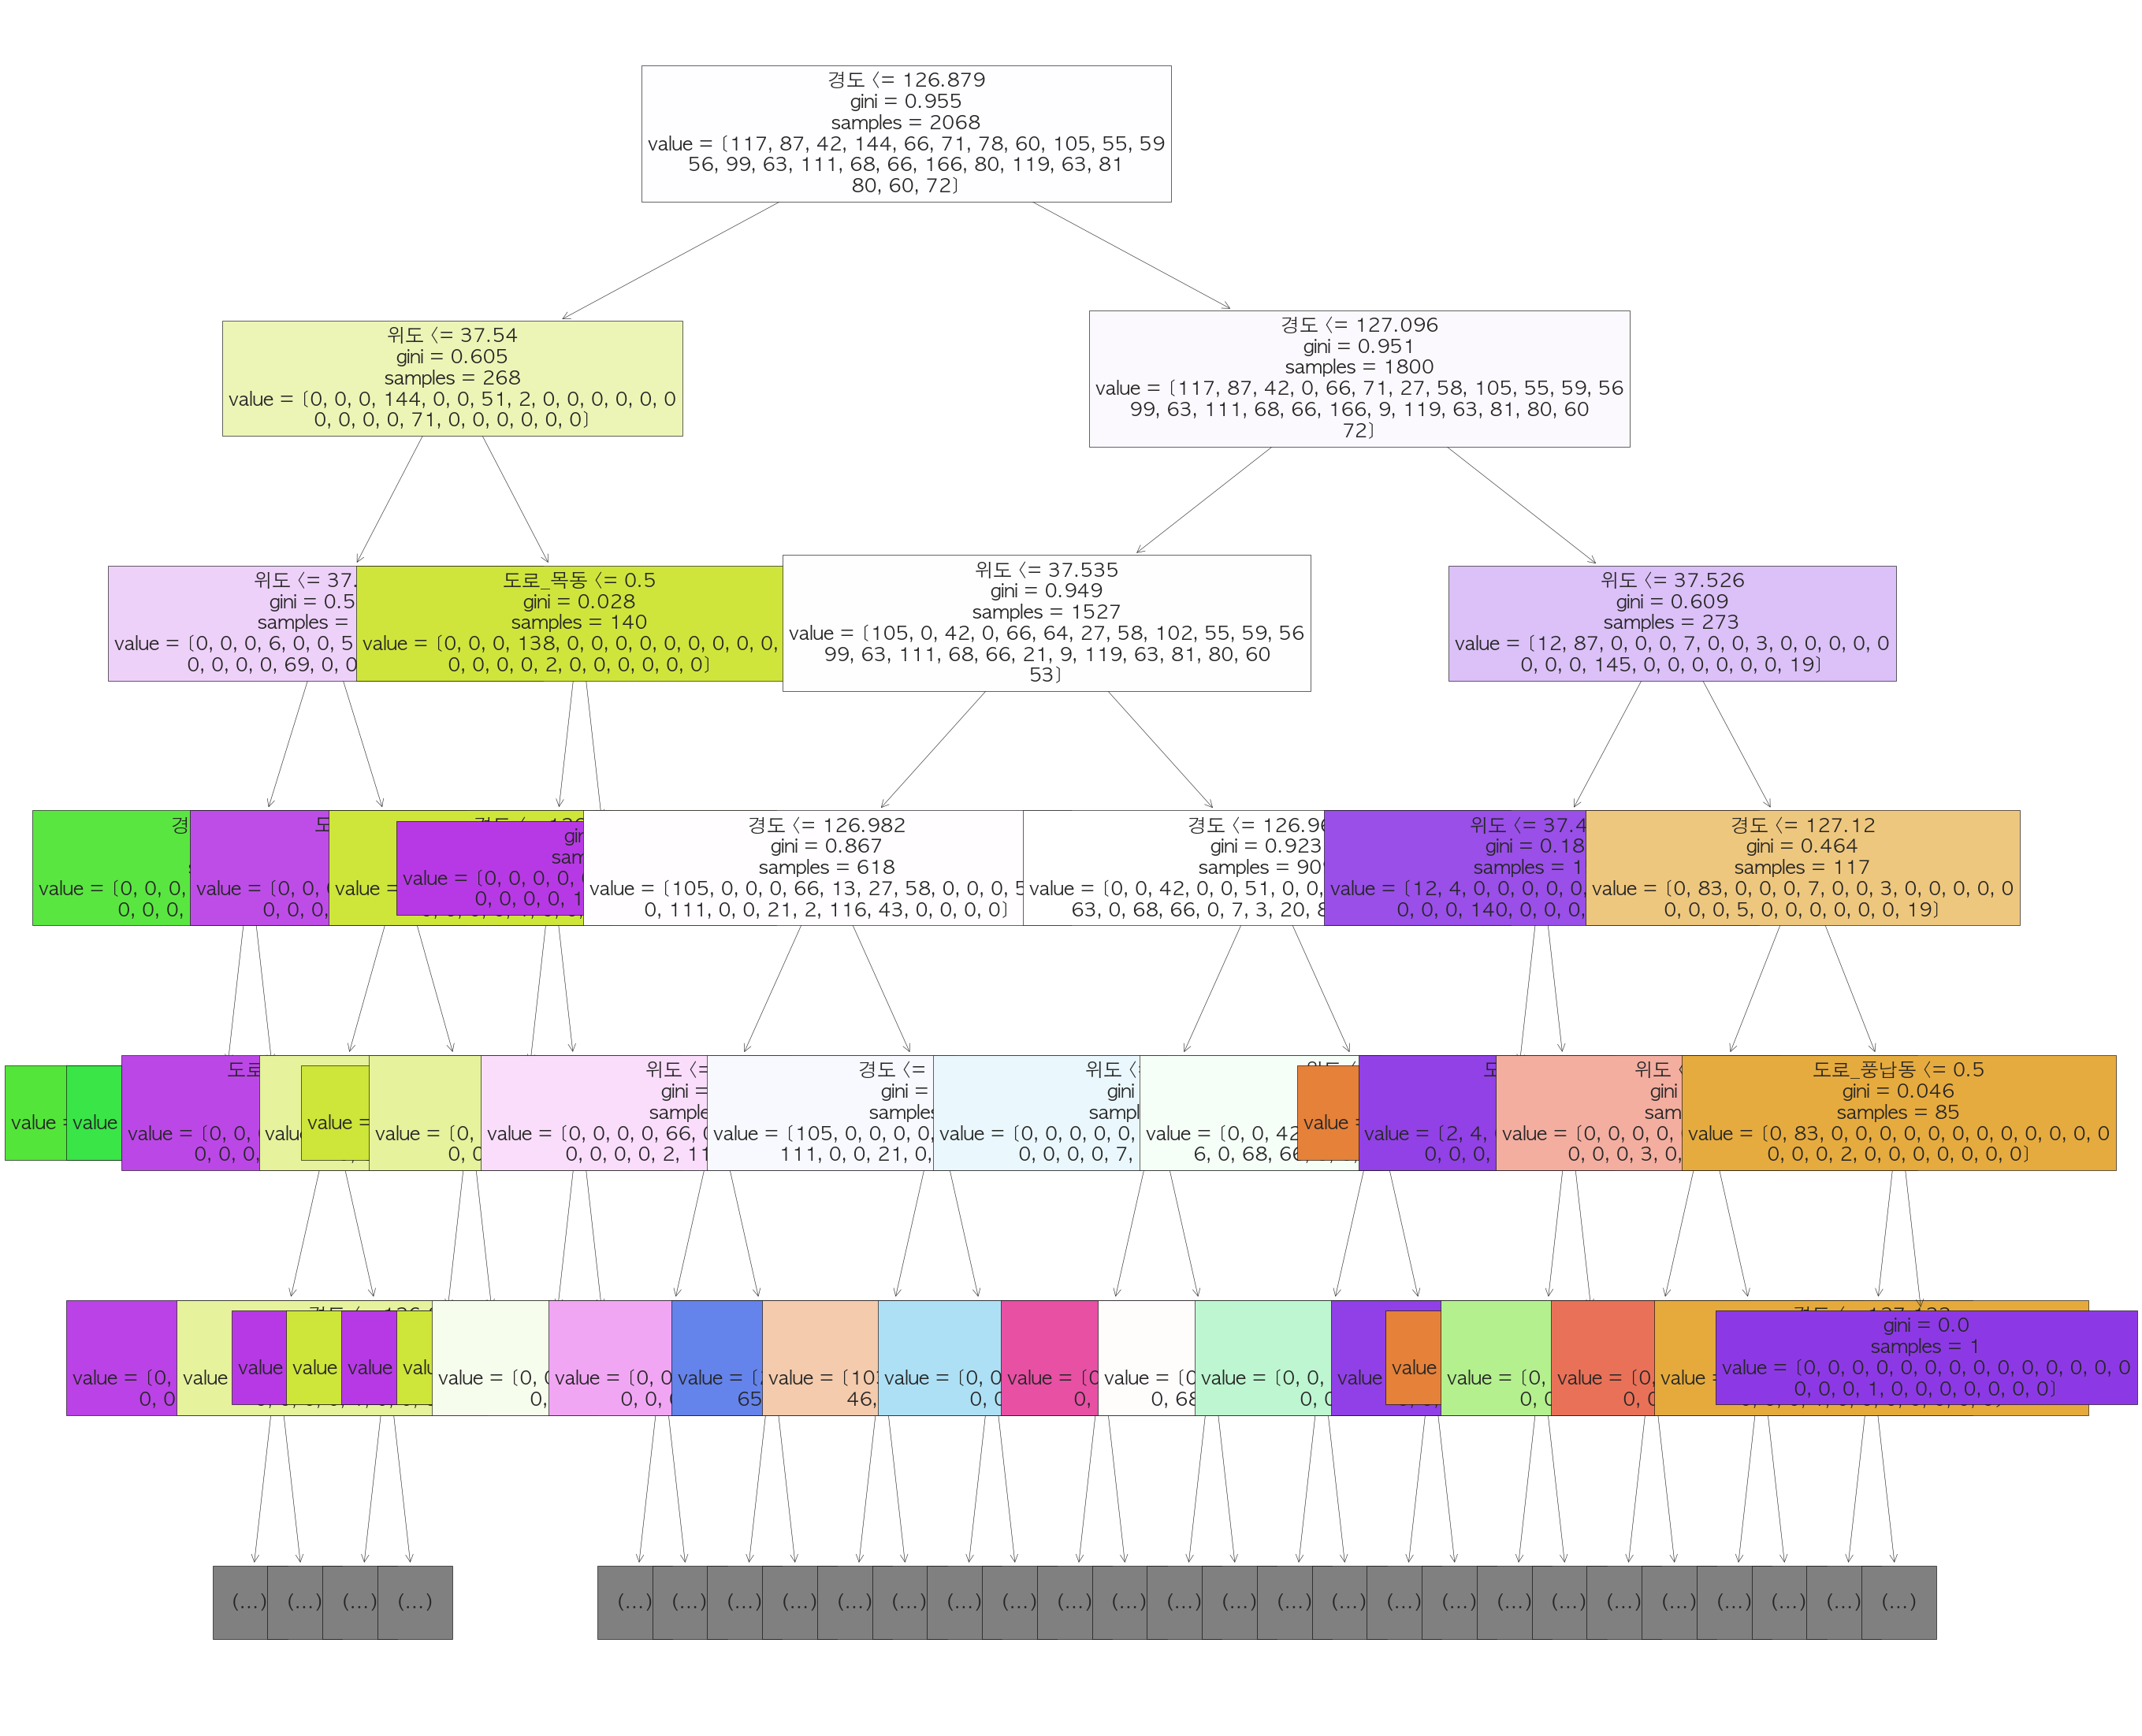

In [94]:
# plot_tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 20))
dtree = plot_tree(model, max_depth=5, fontsize=12, filled=True,
                  feature_names=feature_names_out)

In [109]:
# 피처의 중요도를 추출하기

model.feature_importances_

array([4.20777382e-01, 4.89588023e-01, 1.85657827e-03, 0.00000000e+00,
       3.43828651e-03, 3.70661283e-03, 6.92485928e-03, 1.41208815e-02,
       4.35687500e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.16018801e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.54661207e-04,
       8.86094173e-04, 0.00000000e+00, 0.00000000e+00, 9.97786716e-04,
       0.00000000e+00, 9.68865362e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.68010619e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.45167118e-04, 0.00000000e+00,
      

In [114]:
# nlargest 로 상위 10개 피처 가져오기
fi = pd.Series(model.feature_importances_)
fi.index = feature_names_out
fi.nlargest(20)

경도          0.489588
위도          0.420777
일           0.014121
월           0.006925
도로_미아동      0.005502
도로_번동       0.004414
도로_남부순환로    0.003981
연도          0.003707
자전거수        0.003438
도로_상도로      0.002934
도로_동일로      0.001907
도로_자양동      0.001903
LCD         0.001857
도로_수색로      0.001424
도로_도곡로      0.001385
도로_신대방동     0.001350
도로_삼양로      0.001215
도로_가로공원로    0.001160
도로_등촌로      0.001069
도로_강서로      0.000998
dtype: float64

<AxesSubplot:>

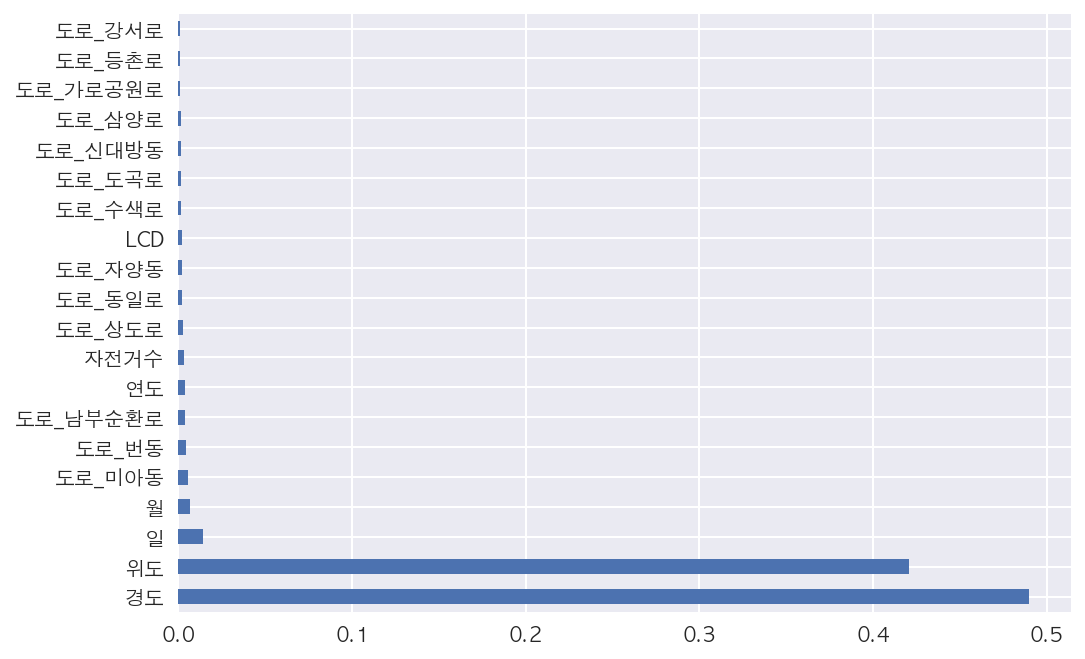

In [116]:
# 피처의 중요도 시각화 하기
# nlargest 로 상위 10개만 가져와서 시각화 합니다.
fi.nlargest(20).plot.barh()

## 정확도(Accuracy) 측정하기

* 모델이 얼마나 잘 예측했는지 측정해 봅니다.
* 시험을 보고 나서 몇 개 맞았는지 틀렸는지 채점해 보는 과정과 유사합니다.
* 실전 문제에서는 답이 없어서 우리가 예측을 해야겠지만 이 실습은 정답이 있는 모의고사 입니다. 
* 모의고사를 보면 내 실력이 어느정도 되는지 예측해 볼 수 있는 것 처럼 점수를 측정해 봅니다.

In [102]:
# 예측의 정확도를 구합니다. 100점 만점 중에 몇 점을 맞았는지 구한다고 보면 됩니다.
(y_test == y_predict).mean()

0.8976833976833977

In [103]:
# 위에서 처럼 직접 구할 수도 있지만 미리 구현된 알고리즘을 가져와 사용합니다.
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict)

0.8976833976833977

In [104]:
# model 의 score 로 점수를 계산합니다.
model.score(X_test, y_test)

0.8976833976833977

## 혼동 행렬 confusion matrix
* 지도 학습으로 훈련된 분류 알고리즘의 성능을 시각화 할 수 있는 표

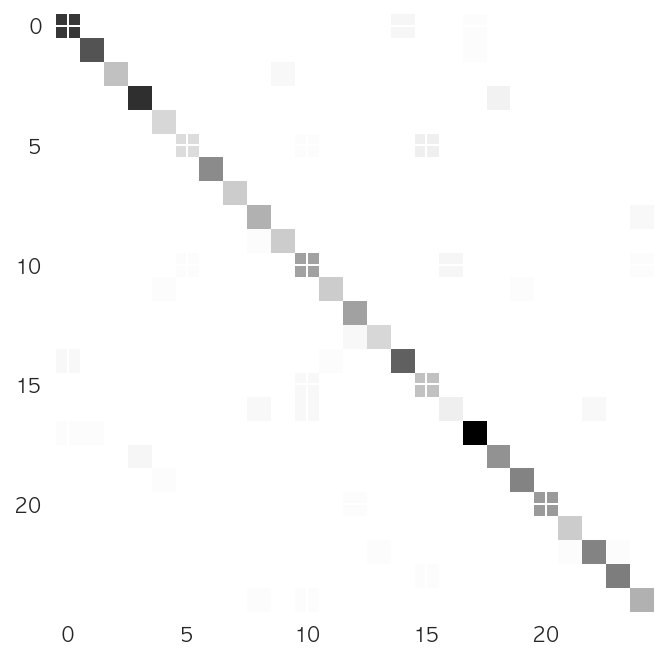

In [119]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(y_test, y_predict))

In [120]:
pd.crosstab(y_test, y_predict)

col_0,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,도봉구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
자치구,,,,,,,,,,,,,,,,,,,,,
강남구,32,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
강동구,0,29,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
강북구,0,0,14,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
강서구,0,0,0,33,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
관악구,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
광진구,0,0,0,0,0,9,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
구로구,0,0,0,0,0,0,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0
금천구,0,0,0,0,0,0,0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
노원구,0,0,0,0,0,0,0,0,16,0,...,0,0,0,0,0,0,0,0,0,2
